<a href="https://colab.research.google.com/github/AustinHLee2/donkeycar/blob/master/visualize_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing attention on self driving car

So far we have seen many examples of attention and activation maximization on `Dense` layers that outputs a probability distribution. What if we have a regression model instead?

In this example, we will use a pretrained self driving car model that predicts the steering angle output. This model is borrowed from https://github.com/experiencor/self-driving-toy-car. Here is the model in action.

<a href="https://www.youtube.com/watch?v=-v6q2dNZTU8" rel="some text"><p align="center">![Link to video](https://img.youtube.com/vi/-v6q2dNZTU8/0.jpg)</p></a>

Lets load the model, weights etc and make a prediction.

In [1]:
#this will upload your files

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving tub_data.tar to tub_data.tar
User uploaded file "tub_data.tar" with length 16317440 bytes


In [0]:
!tar -xf tub_data.tar

In [3]:
#this will upload your files

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving mypilot to mypilot
User uploaded file "mypilot" with length 3267552 bytes


In [4]:
ls

mypilot  sample_data/  tub/  tub_data.tar


In [5]:
!pip install keras-vis

In [6]:
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

def default_linear():
    img_in = Input(shape=(120, 160, 3), name='img_in')
    x = img_in

    # Convolution2D class name is an alias for Conv2D
    x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
    x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

    x = Flatten(name='flattened')(x)
    x = Dense(units=100, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    x = Dense(units=50, activation='linear')(x)
    x = Dropout(rate=.1)(x)
    # categorical output of the angle
    angle_out = Dense(units=1, activation='linear', name='angle_out')(x)

    # continous output of throttle
    throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.5, 'throttle_out': .5})

    return model

Using TensorFlow backend.


In [0]:
import re 
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [10]:
model = default_linear()
model.load_weights('mypilot')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 37, 32)   19232       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 12, 17, 64)   51264       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Predicted [-0.07621662]


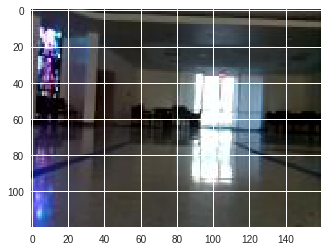

In [8]:
import numpy as np
import time

from matplotlib import pyplot as plt
from glob import iglob
%matplotlib inline

#from model import build_model, FRAME_W, FRAME_H
from keras.preprocessing.image import img_to_array
from vis.utils import utils

FRAME_H = 120
FRAME_W = 160

IMG_PATH = 'tub/10_cam-image_array_.jpg'

model = default_linear()
model.load_weights('mypilot')
img = utils.load_img(IMG_PATH, target_size=(FRAME_H, FRAME_W))
plt.imshow(img)

# Convert to BGR, create input with batch_size: 1.
bgr_img = utils.bgr2rgb(img)
img_input = np.expand_dims(img_to_array(bgr_img), axis=0)
pred = model.predict(img_input)[0][0]
print('Predicted {}'.format(pred))

Looks good. The negative value is indicative of left steering.

## Attention

By default, `visualize_saliency` and `visualize_cam` use positive gradients which shows what parts of the image increase the output value. This makes sense for categorical outputs. For regression cases, it is more interesting to see what parts of the image cause the output to:

- Increase
- Decrease
- Maintain

the current predicted value. This is where `grad_modifiers` shine.

- To visualize decrease, we need to consider negative gradients that indicate the decrease. To treat them as positive values (as used by visualization), we need to to negate the gradients. This is easily done by using `grad_modifier='negate'`.
- To visualize what is responsible for current output, we need to highlight small gradients (either positive or negative). This can be done by using a grad modifier that performs `grads = np.abs(1. / grads)` to magnify small positive or negative values. Alternatively, we can use `grad_modifier='small_values'` which does the same thing.

Lets use this knowledge to visualize the parts of the image that cause the car to increase, decrease, maintain the predicted steering.

That was anti-climactic. Lets try grad-CAM. We know that vanilla saliency can be noisy.

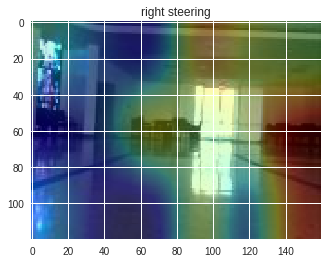

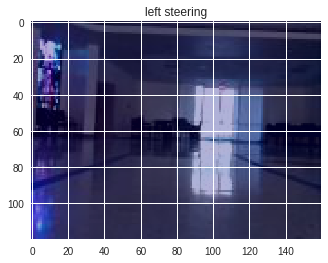

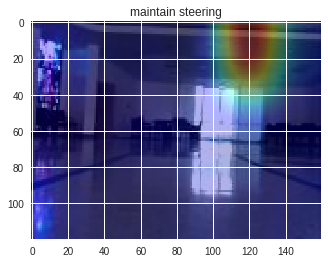

In [10]:
from vis.visualization import visualize_cam

for i, modifier in enumerate(modifiers):
    heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0, 
                            seed_input=bgr_img, grad_modifier=modifier)
    plt.figure()
    plt.title(titles[i])
    # Overlay is used to alpha blend heatmap onto img.
    plt.imshow(overlay(img, heatmap, alpha=0.7))

This makes sense. In order to turn right, the left part of the lane contributes the most towards it. I am guessing it is attending to the fact that it curves left and so changing it to curve right would make the network increase the steering angle.

The `maintain_steering` visualization shows that its current decision is mostly due to the object in the right corner. This is an undesirable behavior which visualizations like these can help you uncover.

The `left steering` case is intuitive as well. Interestingly, the objects in the room in the far right also provide it a cue to turn left. This means that, even without the lane marker, the network will probably turn away from obstacles. Lets put this hypothesis to test. Using my awesome photo editing skills, I will remove the lane marker.

Lets see the predicted output first.

Predicted [-0.07621662]


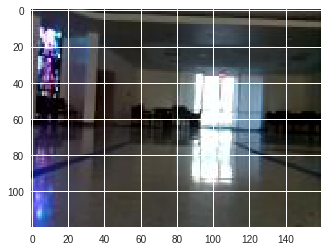

In [11]:
img = utils.load_img(IMG_PATH, target_size=(120, 160))
plt.imshow(img)

# Convert to BGR, create input with batch_size: 1.
bgr_img = utils.bgr2rgb(img)
img_input = np.expand_dims(img_to_array(bgr_img), axis=0)
img_input.shape

pred = model.predict(img_input)[0][0]
print('Predicted {}'.format(pred))

As predicted, it has a left steering output. Lets find out if those objects have anything to do with it.

In [0]:
# We want to use grad_modifier='small_values' to see what is resposible for maintaining current prediction.
imgs = []
heatmap = visualize_cam(model, layer_idx=-1, filter_indices=0,seed_input=bgr_img, grad_modifier='small_values')

As hypothesized, those objects indeed cause the toy car to go left.

> *This single example already provides some pretty good insight into network behavior. If your toy self driving car makes a mistake, we can easily use that example to glean why and add counter examples to the training set to correct that behavior.*